# 2階層でのPredictie Codingの確認

In [50]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
from dataset import Dataset

I_scale = 1.0
dataset = Dataset(scale=I_scale)

In [52]:
#k1 = 0.5
#k2 = 1.0

k1 = 0.0005 # rの学習率
k2 = 0.005 # Uの学習率
iteration = 30

sigma_sq    = 1.0  # Iの生成観測分布の分散
sigma_sq_td = 10.0 # rの生成観測分布の分散
alpha1      = 1.0  # rの事前分布の精度パラメータ  (分散=1.0, 標準偏差1.0)
alpha2      = 0.05 # rhの事前分布の精度パラメータ (分散=20.0, 標準偏差4.5)
lambd       = 0.02 # Uの事前分布の精度パラメータ　(分散=50.0, 標準偏差7.1)

U_scale     = 7.0

Us  = (np.random.rand(3,256,32)-0.5) * U_scale
Uh  = (np.random.rand(96,128)  -0.5) * U_scale
rs  = np.zeros([96],  dtype=np.float32)
rh  = np.zeros([128], dtype=np.float32)

patch_size = len(dataset.patches) # 2375

for k in range(patch_size):
    rs = np.zeros([96], dtype=np.float32)
    rh = np.zeros([128], dtype=np.float32)    
    error_tds = np.zeros([96], dtype=np.float32)
    
    for i in range(iteration):
        r_tds = Uh.dot(rh)
        
        for j in range(3):
            I = dataset.get_image(k, j)
            r    = rs[32*j:32*(j+1)]
            r_td = r_tds[32*j:32*(j+1)]
            U = Us[j]
            Ur = U.dot(r)
            error    = I - Ur
            error_td = r_td - r
            dr = (k1 / sigma_sq) * U.T.dot(error) + (k1/sigma_sq_td) * error_td - k1 * alpha1 * r
            dU = (k2 / sigma_sq) * np.outer(error, r) - k2 * lambd * U
            rs[32*j:32*(j+1)] += dr
            Us[j] += dU            
            error_tds[32*j:32*(j+1)] = error_td
            
        # こちらはerror_tdsは反転する必要ある
        drh = (k1 / sigma_sq_td) * Uh.T.dot(-error_tds)     - k1 * alpha2 * rh
        dUh = (k2 / sigma_sq_td) * np.outer(-error_tds, rh) - k2 * lambd * Uh        

        rh += drh
        Uh += dUh

    if k % 100 == 0:
        print("us mean={} std={}".format(np.mean(Us[0]), np.std(Us[0])))                                    
        print("rs mean={} std={}".format(np.mean(rs), np.std(rs)))
    
    if k % 40 == 0:
        k2 = k2 / 1.015

us mean=-0.03773327144257137 std=2.020868857425088
rs mean=2.501327377525892e-18 std=3.896841248292413e-17
us mean=-0.028217289090693893 std=1.5089785811093797
rs mean=-7.430387631757185e-05 std=0.0017706904327496886
us mean=-0.02144643091978294 std=1.138408916858202
rs mean=-0.00173336046282202 std=0.012536665424704552
us mean=-0.016461536840173947 std=0.8682065290466296
rs mean=-0.000554391648620367 std=0.01993180252611637
us mean=-0.01280339346754192 std=0.6685760135128296
rs mean=7.593942366891034e-18 std=1.032562676507248e-16
us mean=-0.010064543743154047 std=0.5201791637381022
rs mean=-0.0008357830229215324 std=0.007704325020313263
us mean=-0.010824482466991671 std=0.4400828588338179
rs mean=0.024519657716155052 std=0.19493483006954193
us mean=-0.01614166249899558 std=0.4600180301040211
rs mean=-0.023595241829752922 std=0.1447647660970688
us mean=-0.013609140146747783 std=0.46537039774605304
rs mean=-0.0034253152552992105 std=0.09741000086069107
us mean=-0.008092296350689702 std=

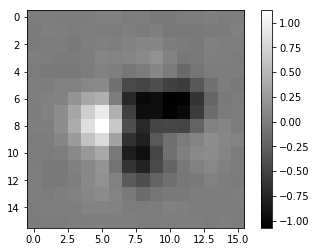

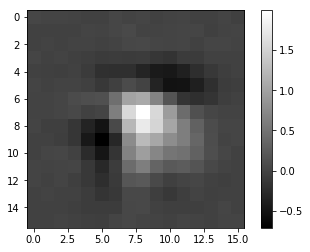

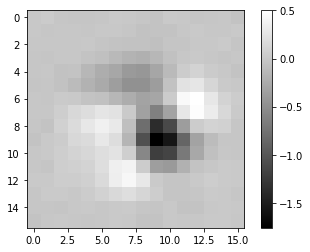

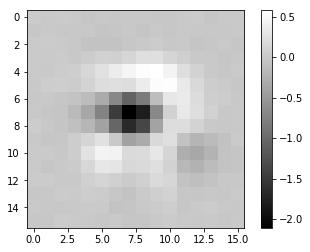

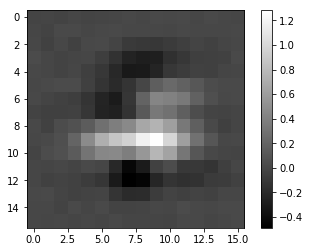

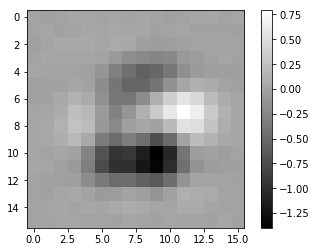

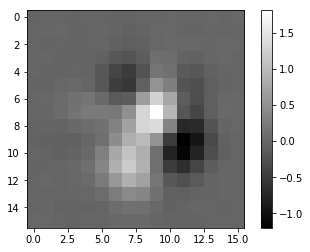

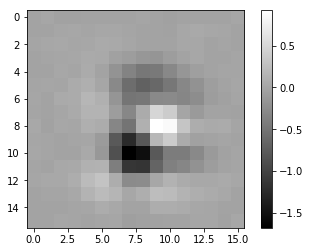

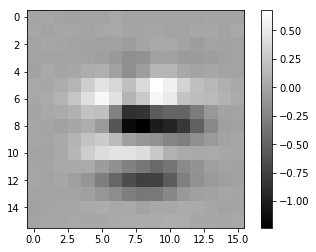

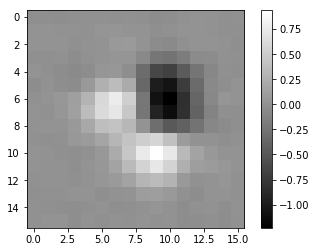

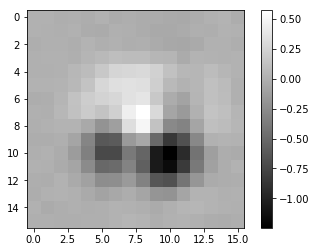

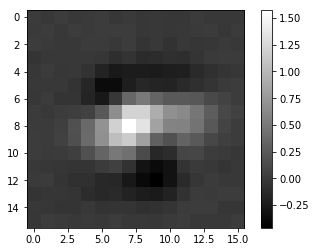

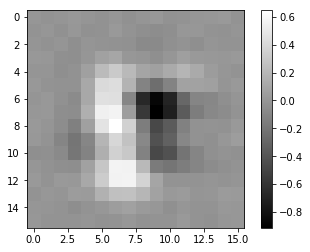

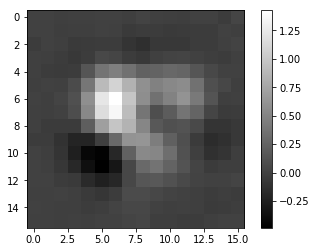

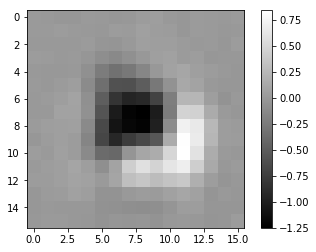

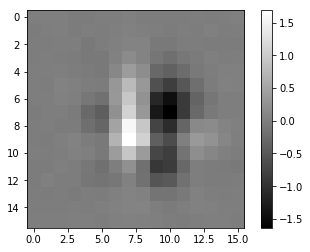

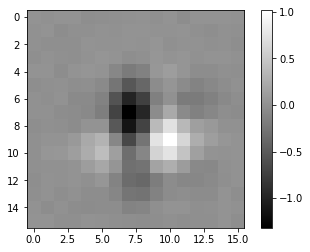

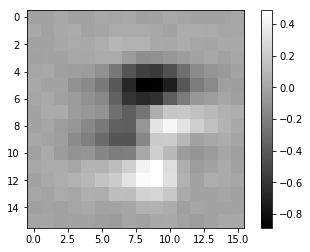

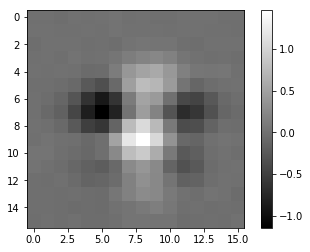

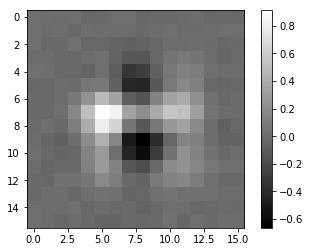

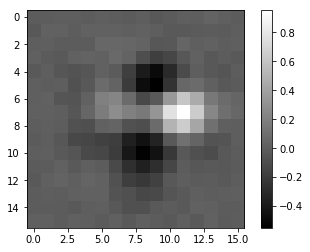

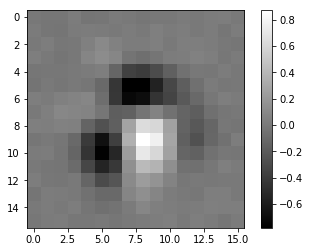

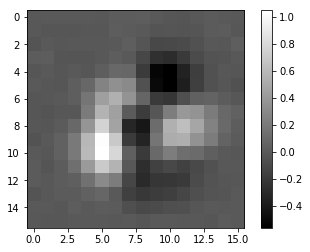

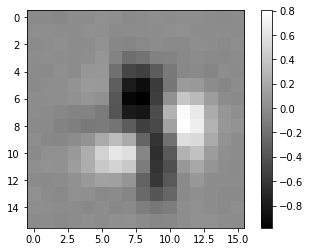

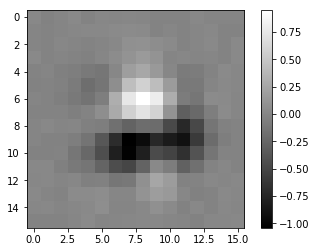

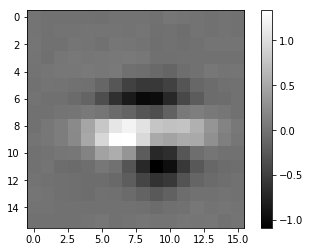

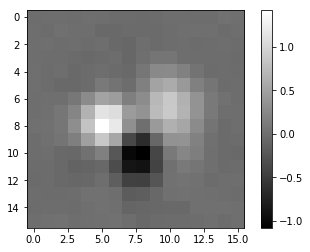

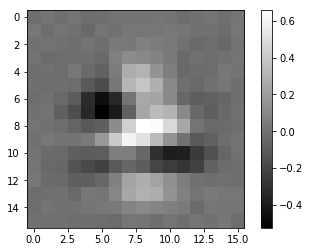

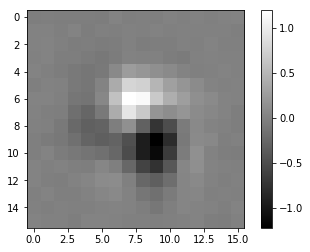

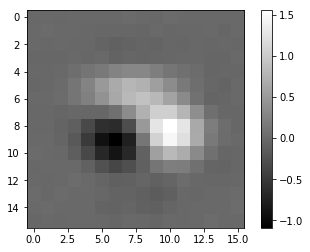

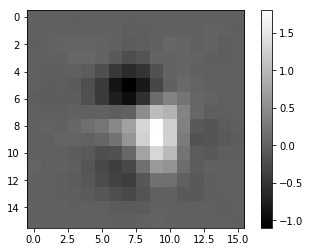

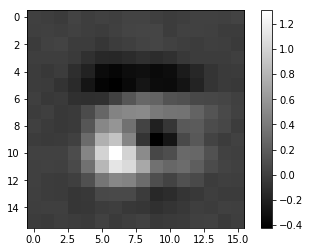

In [53]:
for i in range(32):
    u = Us[1][:,i].reshape(16,16)
    plt.figure()
    plt.imshow(u, cmap='gray')
    plt.colorbar()
    plt.show()

In [56]:
print(Uh.shape) # (96, 128)
print(np.mean(Uh))
print(np.std(Uh))
print(np.std(Us))
print(np.std(rs))

(96, 128)
-2.0071349872936878e-05
0.01847812817799643
0.27242255425920875
0.0034689354


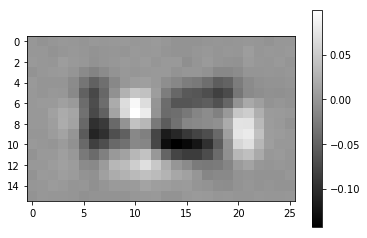

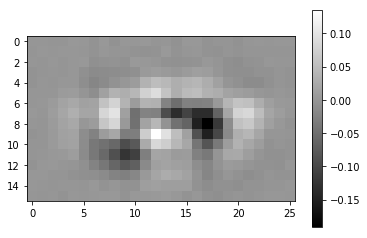

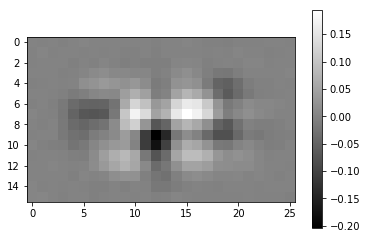

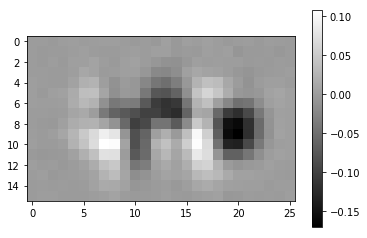

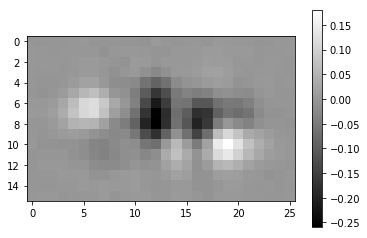

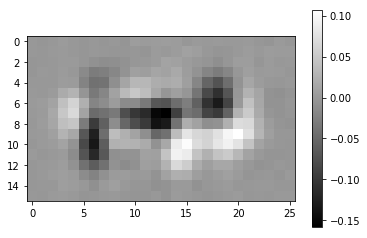

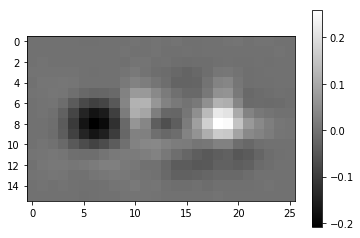

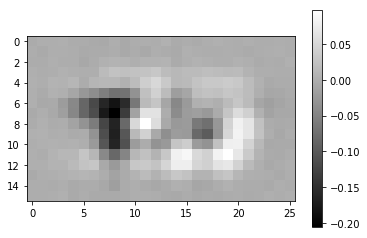

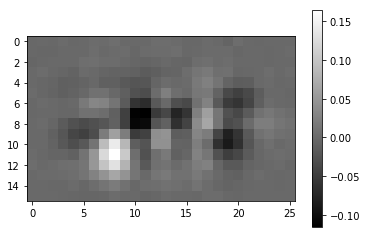

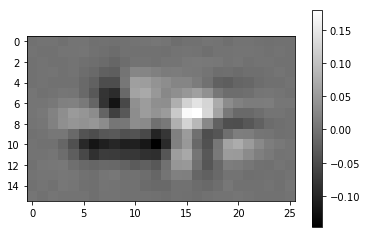

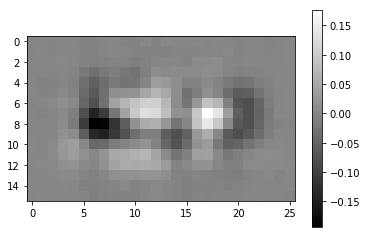

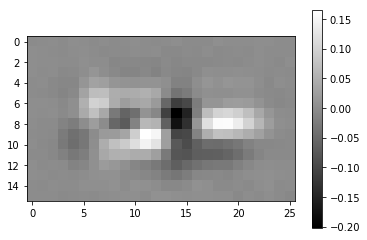

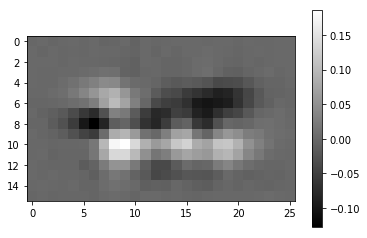

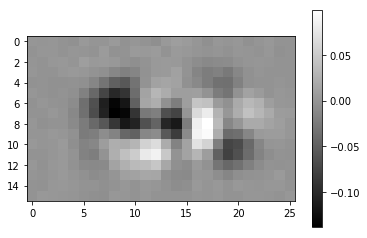

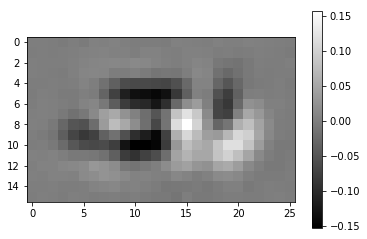

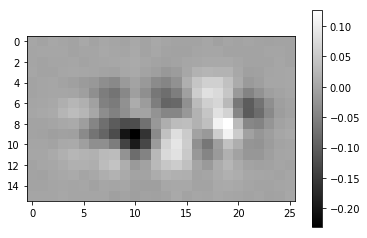

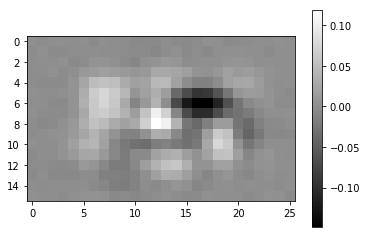

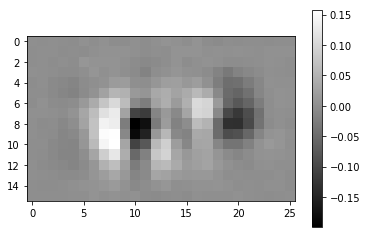

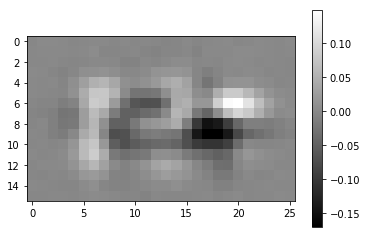

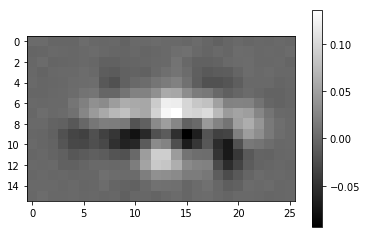

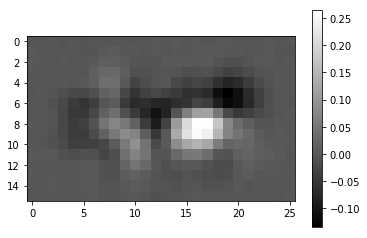

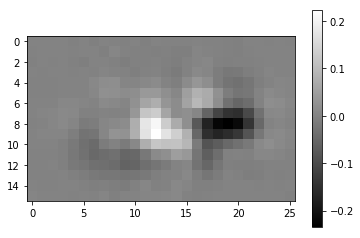

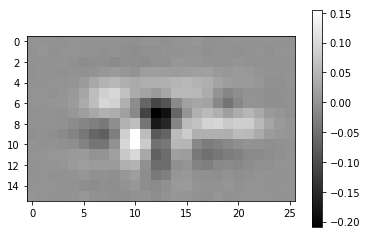

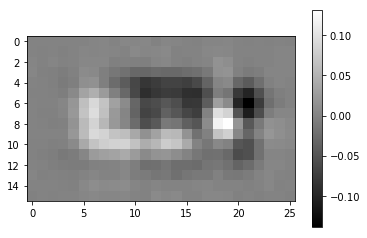

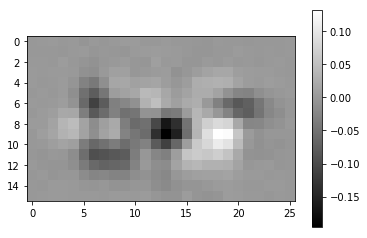

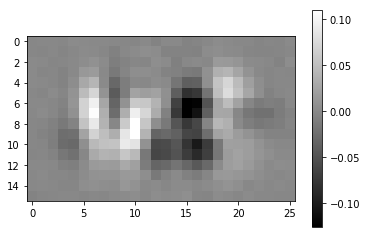

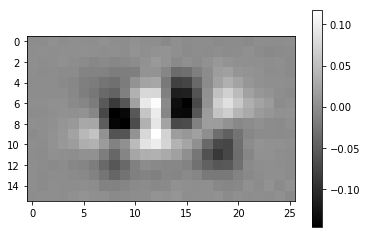

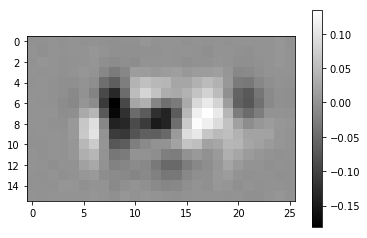

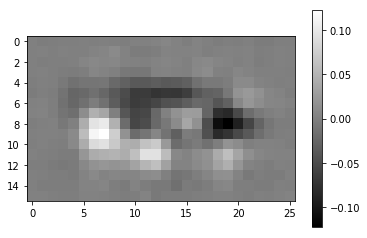

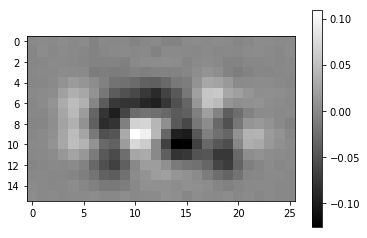

In [40]:
def get_level2_rf(index):
    Uh0 = Uh[:,index][0:32]
    Uh1 = Uh[:,index][32:64]
    Uh2 = Uh[:,index][64:96]

    UU0 = Us[0].dot(Uh0).reshape((16,16))
    UU1 = Us[1].dot(Uh1).reshape((16,16))
    UU2 = Us[2].dot(Uh2).reshape((16,16))

    RF = np.zeros((16,26), dtype=np.float32)
    RF[:, 5*0:5*0+16] += UU0
    RF[:, 5*1:5*1+16] += UU1
    RF[:, 5*2:5*2+16] += UU2    
    return RF

for i in range(30):
    rf = get_level2_rf(i)    
    plt.figure()
    plt.imshow(rf, cmap='gray')
    plt.colorbar()
    plt.show()

In [48]:
import imageio
import cv2
import os

In [49]:
if not os.path.exists("result"):
    os.mkdir("result")

for i in range(32):
    u1 = Us[1][:,i].reshape(16,16)
    u1 = cv2.resize(u1, None, fx=4, fy=4, interpolation=cv2.INTER_NEAREST)
    imageio.imwrite("result/u1_{:0>2}.png".format(i), u1)
    
for i in range(128):
    u2 = get_level2_rf(i)
    u2 = cv2.resize(u2, None, fx=4, fy=4, interpolation=cv2.INTER_NEAREST)
    imageio.imwrite("result/u2_{:0>3}.png".format(i), u2)